# 串接過去資料作訓練對當前測試結果的影響

In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
from sklearn.metrics import r2_score
from dataPreprocess import read_dataset
from model_tf import simpleDecodeModel

In [ ]:
trainSesionIndexList = [[4], [4, 3], [4, 3, 2], [4, 3, 2, 1], [4, 3, 2, 1, 0]]
testSessionIndexList = [4]

In [ ]:
folderPath = './data'
fileList = sorted([i for i in os.listdir(folderPath) if i.endswith('.pkl.zip')])

In [ ]:
for _ in range(5): # 重跑訓練次數(不是epoch!)
    for trainSessionIndexs, testSessionIndex in  itertools.product(trainSesionIndexList, testSessionIndexList):
        print('train', trainSessionIndexs, 'test', testSessionIndex)
        # training dataset
        train_x, train_y = [], []
        for trainSessionIndex in trainSessionIndexs:
            trainSessionName = fileList[trainSessionIndex]
            trainSessionDataset = read_dataset(os.path.join(folderPath, trainSessionName), ['velocity_x', 'velocity_y'])

            train_x.append(trainSessionDataset['m1'][:5000, -5:, :])
            train_y.append(trainSessionDataset['movement'][:5000])

        train_x = np.concatenate(train_x, axis=0)
        train_y = np.concatenate(train_y, axis=0)
        

        # testing dataset
        testSessionName = fileList[testSessionIndex]
        testSessionDataset = read_dataset(os.path.join(folderPath, testSessionName), ['velocity_x', 'velocity_y'])

        test_x = testSessionDataset['m1'][5000:, -5:, :]
        test_y = testSessionDataset['movement'][5000:]

        #
        train_mean, train_std = train_y.mean(), train_y.std()
        train_y = (train_y - train_mean) / train_std


        #
        model = simpleDecodeModel()
        model.compile(optimizer='adam', loss='mse')

        #
        model.fit(x=train_x, y=train_y, batch_size=128, epochs=100, shuffle=True, verbose=0)

        #
        pred = model.predict(x=test_x)
        pred = pred * train_std - train_mean

        # 計算R2
        r2 = [r2_score(y_pred=pred[:, i], y_true=test_y[:, i]) for i in range(pred.shape[-1])]
        print(r2)
        
        #
        df = pd.DataFrame({        
            'trainSession': [trainSessionIndexs],
            'testSession': [testSessionIndex],
            'axis': [['x', 'y']],
            'r_square':[r2],
        })  

        df = df.explode(['axis', 'r_square'])   
        df.to_csv('./results/trainingDataSession.csv', index=False, header=False, mode='a')

## 讀檔畫圖

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dataPreprocess import read_dataset

sns.set_theme(style='whitegrid', font_scale=2)

(0.6, 0.8)

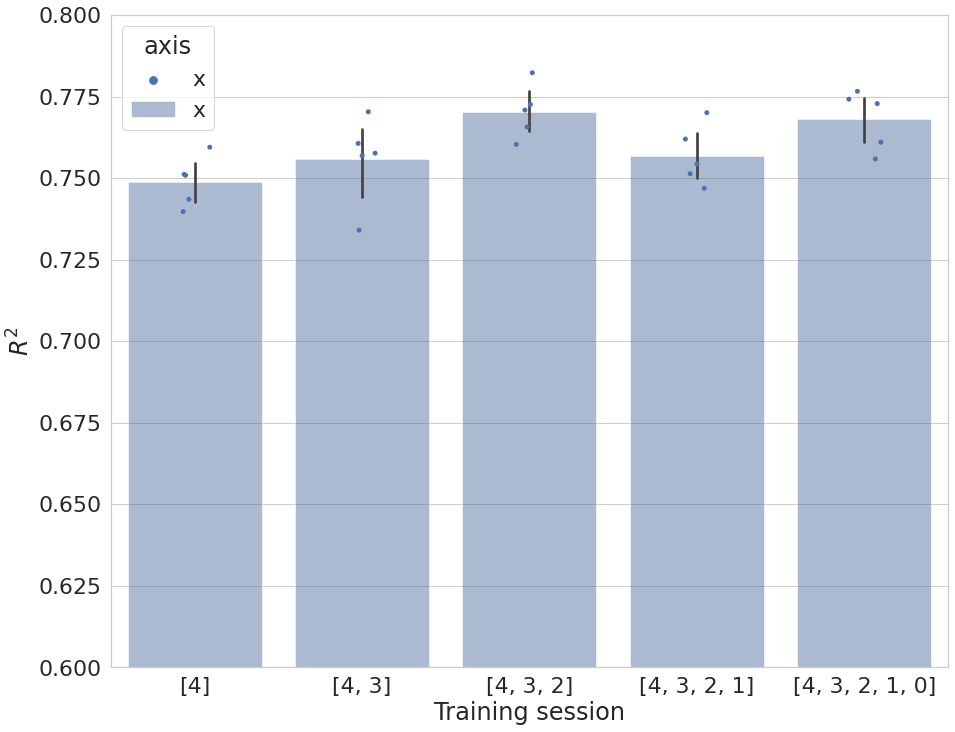

In [3]:
sns.set_theme(style='whitegrid', font_scale=2)
df = pd.read_csv('./results/experiments/trainingDataSession.csv')
df = df[df['axis'] == 'x']



fig, ax = plt.subplots(1, 1, figsize=(15, 12))

sns.barplot(ax=ax, data=df, x='trainSession', y='r_square', hue='axis', alpha=0.5)
sns.stripplot(ax=ax, data=df, x='trainSession', y='r_square', hue='axis', dodge=True)

ax.set_xlabel('Training session')
ax.set_ylabel('$R^2$')
ax.set_ylim([0.6,0.8])

(0.6, 0.8)

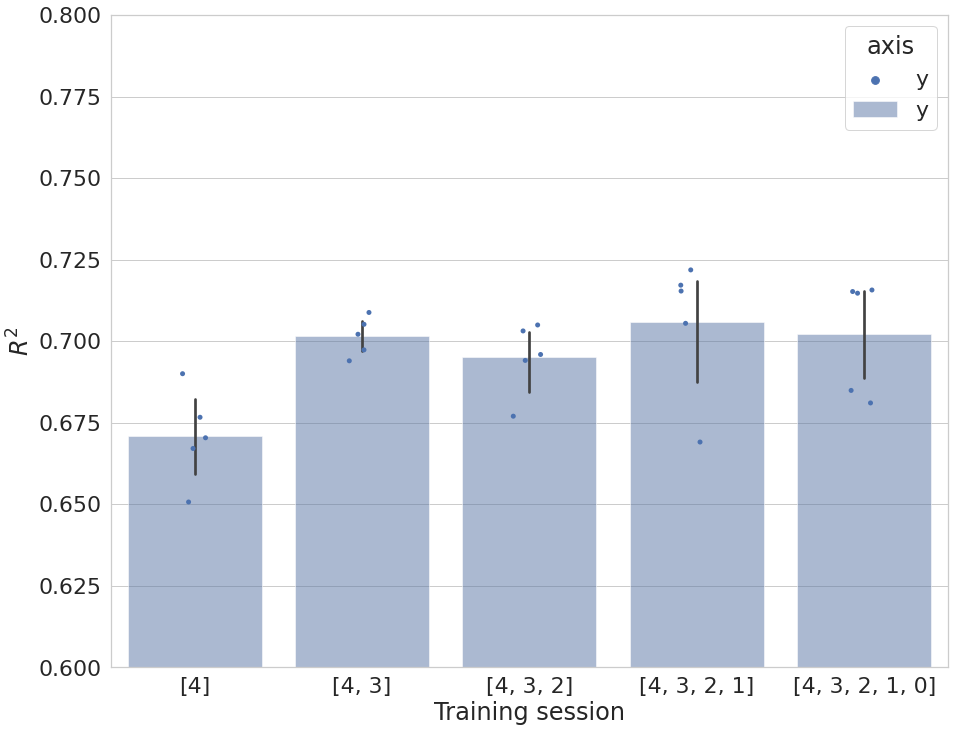

In [4]:
sns.set_theme(style='whitegrid', font_scale=2)
df = pd.read_csv('./results/experiments/trainingDataSession.csv')
df = df[df['axis'] == 'y']

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

sns.barplot(ax=ax, data=df, x='trainSession', y='r_square', hue='axis', alpha=0.5)
sns.stripplot(ax=ax, data=df, x='trainSession', y='r_square', hue='axis', dodge=True)

ax.set_xlabel('Training session')
ax.set_ylabel('$R^2$')
ax.set_ylim([0.6,0.8])